In [43]:
# import packages
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 7)
import time

import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

# Peas in a Pod: 3 planets

Our goal is to derive the inclination precession modes for a peas-in-a-pod system with two ways:
1. Numerical simulation + FFT
2. Analytical derivation

For the 3-planet example, I use the masses ($m$) and semimajor axes ($a$) Kepler-60 system:  
https://aasnova.org/2017/11/20/kepler-planets-tend-to-have-siblings-of-the-same-size/  
https://exoplanets.nasa.gov/exoplanet-catalog/369/kepler-60-b/  
https://exoplanets.nasa.gov/exoplanet-catalog/370/kepler-60-c/  
https://exoplanets.nasa.gov/exoplanet-catalog/371/kepler-60-d/  

We initialize the inclinations so that their relative inclinations are modeled with a Rayleigh distribution with scale 1.8. Later, we will reorient the system so that its total angular momentum axis points along the z-axis (thus changing the inclinations to their "true" values.)  

The values of $e, f, \omega,$ and $\Omega$ are arbitrary.

# Rebound simulation 

In [44]:
# initialize inclinations (this is *not* in the L_tot frame)
rng = default_rng()
inc_scale = 1.8 * np.pi / 180 # inclination scale in radians

## randomly-generated values
b_inc_0_rad = rng.rayleigh(scale=inc_scale)
c_inc_0_rad = rng.rayleigh(scale=inc_scale)
d_inc_0_rad = rng.rayleigh(scale=inc_scale)

## hard-coded values
# b_inc_0_rad = 
# c_inc_0_rad = 
# d_inc_0_rad = 
print(f'b_inc_0_rad = %.9f' % b_inc_0_rad)
print(f'c_inc_0_rad = %.9f' % c_inc_0_rad)
print(f'c_inc_0_rad = %.9f' % d_inc_0_rad)

b_inc_0_rad = 0.027305263
c_inc_0_rad = 0.013039126
c_inc_0_rad = 0.037568492


In [45]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

M_e = 3.00273e-6 # Earth mass in Msun

star_mass = 1.0

# Each planet has 4 provided params: mass (m) in Earth masses, semimajor axis (a), 
# inclination (inc), and Omega. The three omitted orbital params (e, f, omega) 
# are left at their default values of 0.
b_params = {
    "m": 4.19 * M_e, 
    "a": 0.0719, 
    "inc": b_inc_0_rad,
    "Omega": 5.3
}

c_params = {
    "m": 3.85 * M_e, 
    "a": 0.0835,
    "inc": c_inc_0_rad,
    "Omega": 2.3
}

d_params = {
    "m": 4.16 * M_e, 
    "a": 0.1012,
    "inc": d_inc_0_rad,
    "Omega": 0.8
}

sim.add(m=star_mass)
sim.add(m=b_params['m'], a=b_params['a'], inc=b_params['inc'], Omega=b_params['Omega'])
sim.add(m=c_params['m'], a=c_params['a'], inc=c_params['inc'], Omega=c_params['Omega'])
sim.add(m=d_params['m'], a=d_params['a'], inc=d_params['inc'], Omega=d_params['Omega'])

In [46]:
# visualize system before rotation
# op_set = rebound.OrbitPlotSet(sim)

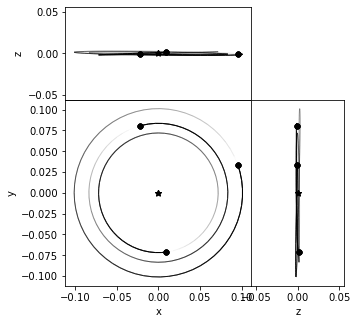

In [47]:
# rotate the axes so that z points along the total angular momentum.
rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum())
sim.rotate(rot)

# visualize system after rotation
op_set = rebound.OrbitPlotSet(sim)

# check that L_tot is aligned along z-axis
# Lx, Ly, Lz = sim.angular_momentum()
# Lx, Ly, Lz

In [48]:
## check the particles' inclinations after the frame shift
print(f"Planet B's inc (L_tot frame) = %.9f" % sim.particles[1].inc)
print(f"Planet C's inc (L_tot frame) = %.9f" % sim.particles[2].inc)
print(f"Planet D's inc (L_tot frame) = %.9f" % sim.particles[3].inc)

Planet B's inc (L_tot frame) = 0.028805732
Planet C's inc (L_tot frame) = 0.020839358
Planet D's inc (L_tot frame) = 0.025502827


## Run sim

In [49]:
tstep = 1
tmax = 8192 # end time of integration (yr)
num_steps = int(tmax / tstep)
N = num_steps

## initialize arrays
b_incs_rad = np.asarray([0.] * num_steps) # inclination of Planet B over the simulation
c_incs_rad = np.asarray([0.] * num_steps) # inclination of Planet C over the simulation
d_incs_rad = np.asarray([0.] * num_steps) # inclination of Planet D over the simulation

b_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet B over the sim
c_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet C over the sim
d_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet D over the sim

b_as = np.asarray([0.] * num_steps) # semimajor axis of Planet B over the simulation
c_as = np.asarray([0.] * num_steps) # a of Planet C over the simulation
d_as = np.asarray([0.] * num_steps) # a of Planet D over the simulation

b_es = np.asarray([0.] * num_steps) # eccentricity of Planet B over the simulation
c_es = np.asarray([0.] * num_steps) # e of Planet C over the simulation
d_es = np.asarray([0.] * num_steps) # e of Planet D over the simulation

times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    # update inclination arrays
    inc_b = sim.particles[1].inc
    inc_c = sim.particles[2].inc
    inc_d = sim.particles[3].inc
    b_incs_rad[i] = inc_b
    c_incs_rad[i] = inc_c
    d_incs_rad[i] = inc_d
    
    # update complex inclination arrays
    Omega_i_b = sim.particles[1].Omega
    Omega_i_c = sim.particles[2].Omega
    Omega_i_d = sim.particles[3].Omega
    b_complex_incs_rad[i] = inc_b * np.exp(1j * Omega_i_b)
    c_complex_incs_rad[i] = inc_c * np.exp(1j * Omega_i_c)
    d_complex_incs_rad[i] = inc_d * np.exp(1j * Omega_i_d)
    
    # update semimajor axis arrays
    b_as[i] = sim.particles[1].a
    c_as[i] = sim.particles[2].a
    d_as[i] = sim.particles[3].a
    
    # update semimajor axis arrays
    b_es[i] = sim.particles[1].e
    c_es[i] = sim.particles[2].e
    d_es[i] = sim.particles[3].e
    
    # move forward by one timestep
    sim.integrate(t)

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

Integration took 269.5 seconds


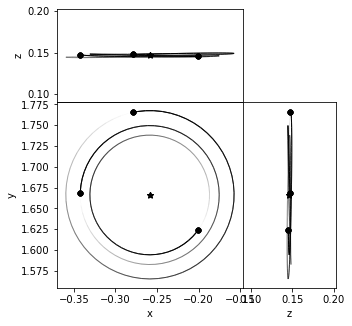

In [50]:
# visualize system after integration
op_set = rebound.OrbitPlotSet(sim)

## Plot simulation results

Max Planet B eccentricity: 0.029369378195576057
Max Planet C eccentricity: 0.033507530723811026
Max Planet D eccentricity: 0.03048706680234233


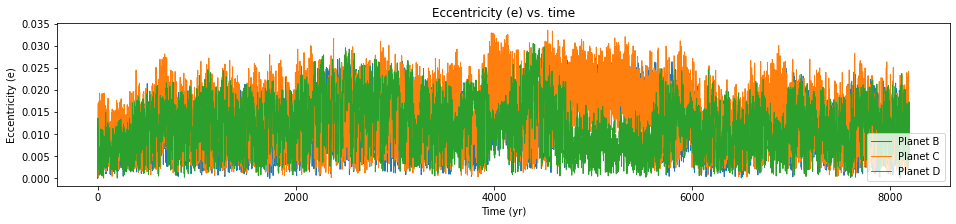

In [86]:
# check that semimajor axes/eccentricities aren't wandering
fig = plt.figure(figsize=(16,3))

# plt.plot(times, b_as, label='Planet B')
# plt.plot(times, c_as, label='Planet C')
# plt.plot(times, d_as, label='Planet D')

# plt.xlabel('Time (yr)')
# plt.ylabel('a (AU)')

# plt.title('Semimajor axis (a) vs. time')
# plt.legend(loc='lower right')
# plt.show()

plt.plot(times, b_es, lw=1, label='Planet B')
plt.plot(times, c_es, lw=1, label='Planet C')
plt.plot(times, d_es, lw=1, label='Planet D')

print(f'Max Planet B eccentricity: {max(b_es)}')
print(f'Max Planet C eccentricity: {max(c_es)}')
print(f'Max Planet D eccentricity: {max(d_es)}')

plt.xlabel('Time (yr)')
plt.ylabel('Eccentricity (e)')

plt.title('Eccentricity (e) vs. time')
plt.legend(loc='lower right')
plt.show()

In [59]:
# convert inclinations from radians to degrees
b_incs_deg = b_incs_rad * (180 / np.pi)
c_incs_deg = c_incs_rad * (180 / np.pi)
d_incs_deg = d_incs_rad * (180 / np.pi)
b_complex_incs_deg = b_complex_incs_rad * (180 / np.pi)
c_complex_incs_deg = c_complex_incs_rad * (180 / np.pi)
d_complex_incs_deg = d_complex_incs_rad * (180 / np.pi)

# save data
file_path = f'bcd_complex_incs_%.1E_yrs.pkl' % tmax
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, b_complex_incs_deg, c_complex_incs_deg, d_complex_incs_deg), f)

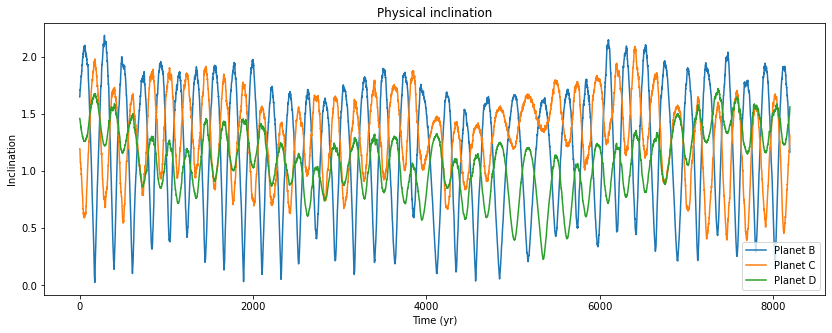

In [62]:
load_data = False

if load_data:    
    tmax = 8192
    file_path = f'bcd_incs_%.1E_yrs.pkl' % tmax

    ## open old data files
    with lzma.open(file_path, 'rb') as f:
        times, b_complex_incs_deg, c_complex_incs_deg, d_complex_incs_deg = pickle.load(f)

    b_incs_deg = np.abs(b_complex_incs_deg)
    c_incs_deg = np.abs(c_complex_incs_deg)
    d_incs_deg = np.abs(d_complex_incs_deg)

fig = plt.figure(figsize=(14,5))

plt.plot(times, b_incs_deg, label='Planet B')
plt.plot(times, c_incs_deg, label='Planet C')
plt.plot(times, d_incs_deg, label='Planet D')

plt.xlabel('Time (yr)')
plt.ylabel('Inclination')
plt.title('Physical inclination')

plt.legend(loc='lower right')
plt.show()

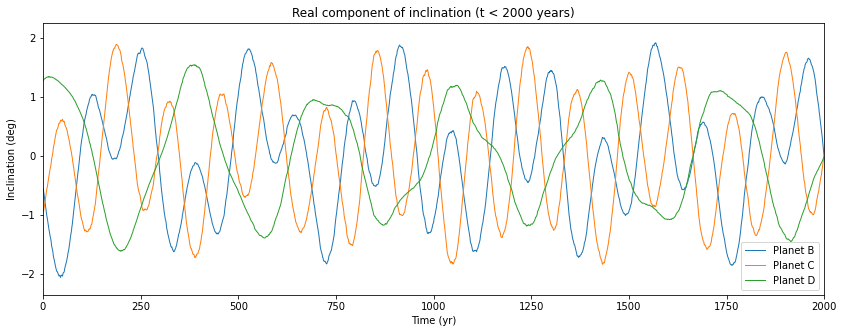

In [68]:
fig = plt.figure(figsize=(14,5))

xlim = 2000

plt.plot(times, b_complex_incs_deg.real, lw=1, label='Planet B')
plt.plot(times, c_complex_incs_deg.real, lw=1, label='Planet C')
plt.plot(times, d_complex_incs_deg.real, lw=1, label='Planet D')

plt.xlabel('Time (yr)')
plt.xlim(0, xlim)
plt.ylabel('Inclination (deg)')
plt.title(f'Real component of inclination (t < {xlim} years)')

plt.legend(loc='lower right')
plt.show()

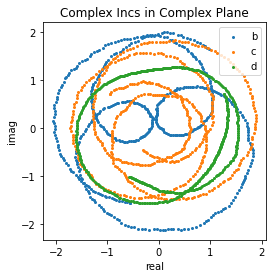

In [69]:
temp_range = slice(0, 500)

plt.figure(figsize=(4,4))

plt.scatter(b_complex_incs_deg.real[temp_range], \
            b_complex_incs_deg.imag[temp_range], s=4, label='b')
plt.scatter(c_complex_incs_deg.real[temp_range], \
            c_complex_incs_deg.imag[temp_range], s=4, label='c')
plt.scatter(d_complex_incs_deg.real[temp_range], \
            d_complex_incs_deg.imag[temp_range], s=4, label='d')

plt.xlabel('real')
plt.ylabel('imag')
plt.title('Complex Incs in Complex Plane')
plt.legend(loc='upper right')
plt.show()

## Run FFT (and interpolation)

In [73]:
temp = np.array([4, 5, 2, 1, 0])
sorted_arr_inds = np.argsort(-temp) # sorted array indices (decreasing order)
temp[sorted_arr_inds[0]]

5

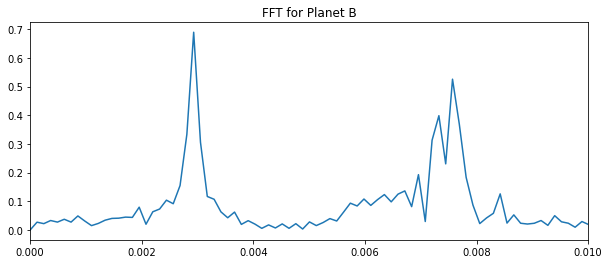

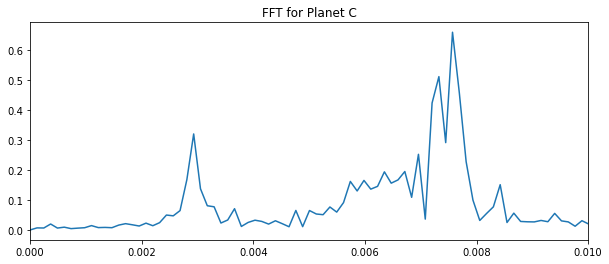

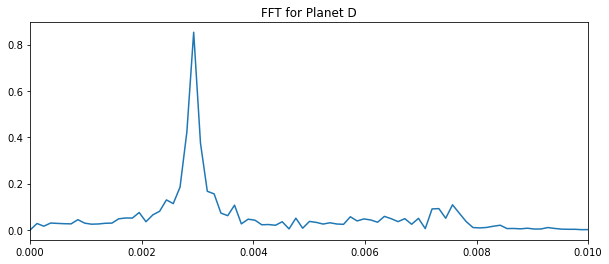

Planet B freqs (yr^-1):  [0.0029297 0.0075684]
Planet B periods (yr):  [341.333 132.129]
Planet B amplitudes (deg):  [0.689579 0.525822]

Planet C freqs (yr^-1):  [0.0075684 0.0073242]
Planet C periods (yr):  [132.129 136.533]
Planet C amplitudes (deg):  [0.660046 0.511834]

Planet D freqs (yr^-1):  [0.0029297 0.0028076]
Planet D periods (yr):  [341.333 356.174]
Planet D amplitudes (deg):  [0.853459 0.422972]


In [85]:
def quad_fn(coeffs, x):
    '''
    Given the coefficients of a quadratic polynomial f(x), return f(x).
    
    PARAMETERS
    ----------
    coeffs: 3-element list containing the quadratic's coefficients, 
    highest power first.
    x: the value at which to evaluate f(x).
    
    '''
    
    a, b, c = coeffs
    
    return a * x**2 + b * x + c

def FFT_freq_amp(incs, planet_name, quad_interp=False):
    '''
    Given a time series (incs) representing either component of complex inclination, 
    return the mode frequencies and amplitudes of the time series. 
    (Might include an option to apply quadratic interpolation around the FFT's peaks.)
    
    NOTE: This implementation is for 3 planets.
        
    ARGUMENTS
    ---------
    incs: time series of either the real or imag component of a complex inclination series
    planet_name: string representing planet name (used in plots)
    quad_interp: if True, uses quadratic interpolation to improve the result
    of low-resolution FFTs; default is False
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.figure(figsize=(10,4))
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 0.01)
    plt.title('FFT for ' + planet_name)
    plt.show()
    
    # get locations of the FFT's two peaks
    sorted_ind_arr = np.argsort(-yf_scaled) # indices to sort yf_scaled in decreasing order
    mode_amp1 = yf_scaled[sorted_ind_arr[0]]
    mode_amp2 = yf_scaled[sorted_ind_arr[1]]
    mode_freq1 = xf[sorted_ind_arr[0]]
    mode_freq2 = xf[sorted_ind_arr[1]]
    
    # run quadratic interpolation on the FFT
    if quad_interp:
        raise RuntimeError("Error: haven't implemented ")
#         x_vals = [xf[np.argmax(yf) - 1], xf[np.argmax(yf)], xf[np.argmax(yf) + 1]]
#         y_vals = np.abs([yf[np.argmax(yf) - 1], yf[np.argmax(yf)], yf[np.argmax(yf) + 1]])
#         y_vals_scaled = 2 / num_steps * np.abs(y_vals)

#         # get coefficients of the interpolated quadratic function
#         coeffs = np.polyfit(x_vals, y_vals_scaled, deg=2)
#         a, b, c = coeffs

#         # get mode freq and amplitude
#         mode_f = - b / (2*a) # peak of the quadratic function
#         mode_amp = quad_fn(coeffs, mode_f)

#         # return period (years) and amplitude
#         return mode_f, mode_amp

    # (result from no quadratic interpolation)
    # return freq (years^-1) and amplitude (degrees)
    return [mode_freq1, mode_freq2], [mode_amp1, mode_amp2]

b_series = b_complex_incs_deg.real
c_series = c_complex_incs_deg.real
d_series = d_complex_incs_deg.real

use_interp = False

b_freqs = np.zeros([2])
b_amps = np.zeros([2])
b_freqs, b_amps = FFT_freq_amp(b_series, 'Planet B', quad_interp=use_interp)
b_periods = [1/freq for freq in b_freqs] # years

c_freqs = np.zeros([2])
c_amps = np.zeros([2])
c_freqs, c_amps = FFT_freq_amp(c_series, 'Planet C', quad_interp=use_interp)
c_periods = [1/freq for freq in c_freqs] # years

d_freqs = np.zeros([2])
d_amps = np.zeros([2])
d_freqs, d_amps = FFT_freq_amp(d_series, 'Planet D', quad_interp=use_interp)
d_periods = [1/freq for freq in d_freqs] # years

if use_interp:
    print('WITH QUADRATIC INTERPOLATION:')
print(f'Planet B freqs (yr^-1): ', np.round(b_freqs,7))
print(f'Planet B periods (yr): ', np.round(b_periods,3))
print(f'Planet B amplitudes (deg): ', np.round(b_amps,6))
print()
print(f'Planet C freqs (yr^-1): ', np.round(c_freqs,7))
print(f'Planet C periods (yr): ', np.round(c_periods,3))
print(f'Planet C amplitudes (deg): ', np.round(c_amps,6))
print()
print(f'Planet D freqs (yr^-1): ', np.round(d_freqs,7))
print(f'Planet D periods (yr): ', np.round(d_periods,3))
print(f'Planet D amplitudes (deg): ', np.round(d_amps,6))

**TODO:**
- Pick out the "right" frequencies and amplitudes
- Write down mode amplitude vectors
- Try curve_fit

### write down mode amplitude vectors

In [87]:
b_fft = 2 / num_steps * np.abs(fft.fft(b_complex_incs_deg.real))
c_fft = 2 / num_steps * np.abs(fft.fft(c_complex_incs_deg.real))
d_fft = 2 / num_steps * np.abs(fft.fft(c_complex_incs_deg.real))

# ...

## `curve_fit` with FFT as initial guess

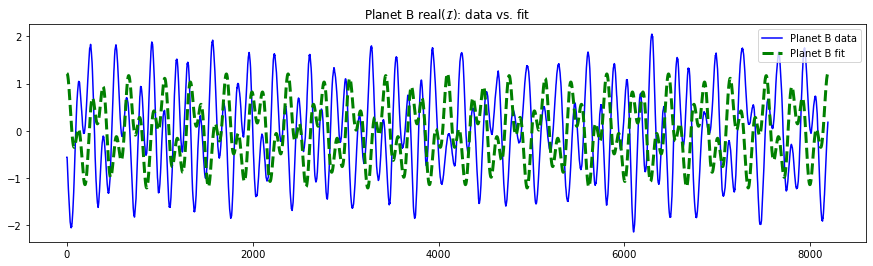

In [92]:
def test_func(x, a, b, c, d):
    '''
    Returns a sum of 2 cosine functions. 
    
    '''
    
    return a * np.cos(b * x + c) + d

# Given our FFT results as an initial guess, use curve_fit to infer the parameters
# of Planet B's complex inclination series (real component).

# ...
# Planet B freqs (yr^-1):  [0.0029297 0.0075684]
# Planet B periods (yr):  [341.333 132.129]
# Planet B amplitudes (deg):  [0.689579 0.525822]
    
plt.figure(figsize=(15,4))

fitted_b_series = test_func(times, b_amps[0], (2*np.pi)*b_freqs[0], 0, 0) + \
         test_func(times, b_amps[1], (2*np.pi)*b_freqs[1], 0, 0)
plt.plot(times, b_series, color='b', label='Planet B data')
plt.plot(times, fitted_b_series, 'g--', lw='3', label='Planet B fit')

plt.title('Planet B real($\mathcal{I}$): data vs. fit')
plt.legend(loc='upper right')
plt.show()

# Analytic formula

In [36]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or u.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [37]:
a_b = sim.particles[1].a * u.au
a_c = sim.particles[2].a * u.au
a_d = sim.particles[3].a * u.au

M_star = sim.particles[0].m * u.M_sun
m_b = sim.particles[1].m * u.M_sun
m_c = sim.particles[2].m * u.M_sun
m_d = sim.particles[3].m * u.M_sun

planet_inds = ['b', 'c', 'd']

# calculate omega_jk values in yr^-1 (but without the unit)
# format: omega_jk = mode_freq(a_j, a_k, m_k, M_star).to(u.yr**-1).value
for j in planet_inds:
    for k in planet_inds:
        if (j == k): continue
        exec('omega_' + j + k + ' = ' + \
             'mode_freq(a_' + j + ', a_' + k +', m_' + k +', M_star).to(u.yr**-1).value')

The below cell gets the eigenvalues of the matrix in Eq. A1 of Su & Lai 2022.

In [38]:
mat = np.array([
    [-omega_bc - omega_bd, omega_bc, omega_bd],
    [omega_cb, -omega_cb - omega_cd, omega_cd],
    [omega_db, omega_dc, -omega_db - omega_dc]
])

eigs, eigv = np.linalg.eig(mat)
prec_freqs = eigs[np.where(np.abs(eigs) > 1e-10)]
prec_eigvs = eigv[:, np.where(np.abs(eigs) > 1e-10)]
prec_eigvs = np.squeeze(prec_eigvs).T # reshape to (2,3), ie each row is an eigv

g_1, g_2 = -prec_freqs

In [41]:
print(f'Period 1: {np.round(2 * np.pi / g_1, 3)} years')
print(f'Period 2: {np.round(2 * np.pi / g_2, 3)} years')
print(f'Non-zero mode frequencies: {-prec_freqs}')

Period 1: 110.744 years
Period 2: 301.739 years
Non-zero mode frequencies: [0.05673614 0.02082327]


In [40]:
# check that eigenvalues and eigenvectors match
print(f"Matrix \"divided\" by eigenvector 1: {np.matmul(mat, prec_eigvs[0]) / prec_eigvs[0]}")
print(f"Matrix \"divided\" by eigenvector 2: {np.matmul(mat, prec_eigvs[1]) / prec_eigvs[1]}")
print(f'Eigenvalues: {eigs}')

Matrix "divided" by eigenvector 1: [-0.05673614 -0.05673614 -0.05673614]
Matrix "divided" by eigenvector 2: [-0.02082327 -0.02082327 -0.02082327]
Eigenvalues: [-5.67361402e-02 -2.08232666e-02 -5.68159233e-18]
